# SeqRep Test

## Preprocessing

In [1]:
from SeqRep.dataset_builder import DatasetBuilder, SILVAHeaderParser
builder = DatasetBuilder(SILVAHeaderParser())
dataset = builder.from_fasta(['SILVA_138.1_SSURef_NR99_tax_silva.fasta'])
# dataset = builder.from_fasta(['small.fasta'])

In [2]:
dataset = dataset.drop_bad_headers()
len(dataset)

334360

In [3]:
kmer_counts = dataset.count_kmers(5, jobs=7, chunksize=100)

100%|████████████████████| 334360/334360 [00:13<00:00, 25480.56it/s]


In [4]:
dataset.trim_seqs(1500)

## Simple Dense Network

The following three cells are to create and train a new version of this model. Below these is code to both save the existing model and load a version from the Models folder.

In [28]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(512)
builder.dense(512)
builder.dense(512)
dense_model = builder.compile(output_dim=2)
dense_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_27 (Dense)            (None, 512)               524800    
                                                                 
 dense_28 (Dense)            (None, 512)               262656    
                                                                 
 dense_29 (Dense)            (None, 512)               262656    
                                                                 
 flatten_8 (Flatten)         (None, 512)               0         
                                                                 
 dense_30 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 1,051,138
Trainable params: 1,051,138
Non-tra

In [29]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
dense_comp = ComparativeEncoder(dense_model, dist=Euclidean())

In [39]:
dense_comp.fit(kmer_counts, batch_size=100, epochs=7, jobs=7, chunksize=500)

Epoch 1:


100%|████████████████████| 334360/334360 [00:16<00:00, 20467.21it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2073
Epoch time: 66.18736982345581
Epoch 2:


100%|████████████████████| 334360/334360 [00:15<00:00, 21931.15it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2076
Epoch time: 65.42476606369019
Epoch 3:


100%|████████████████████| 334360/334360 [00:15<00:00, 20970.10it/s]


3344/3344 [==============================] - 41s 12ms/step - loss: 0.2072
Epoch time: 65.47609329223633
Epoch 4:


100%|████████████████████| 334360/334360 [00:15<00:00, 21226.45it/s]


3344/3344 [==============================] - 43s 13ms/step - loss: 0.2055
Epoch time: 68.72371792793274
Epoch 5:


100%|████████████████████| 334360/334360 [00:17<00:00, 19502.29it/s]


3344/3344 [==============================] - 46s 14ms/step - loss: 0.2045
Epoch time: 71.64712715148926
Epoch 6:


100%|████████████████████| 334360/334360 [00:17<00:00, 19264.74it/s]


3344/3344 [==============================] - 45s 13ms/step - loss: 0.2044
Epoch time: 70.66919183731079
Epoch 7:


100%|████████████████████| 334360/334360 [00:16<00:00, 19878.29it/s]


3344/3344 [==============================] - 44s 13ms/step - loss: 0.2037
Epoch time: 69.23326396942139


In [40]:
dense_comp.save('Models/densenet')

In [5]:
from SeqRep.comparative_encoder import ComparativeEncoder
dense_comp = ComparativeEncoder.load('Models/densenet')

Metal device set to: Apple M1 Pro


2023-01-04 19:17:45.556706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 19:17:45.556839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


This cell actually converts the dataset into representations for downstream plotting.

In [41]:
dense_reprs = dense_comp.transform(kmer_counts, batch_size=100)

3344/3344 [==============================] - 7s 2ms/step


The following four cells are example visualizations. Other visualizations are possible by adjusting masks and taxonomic levels.

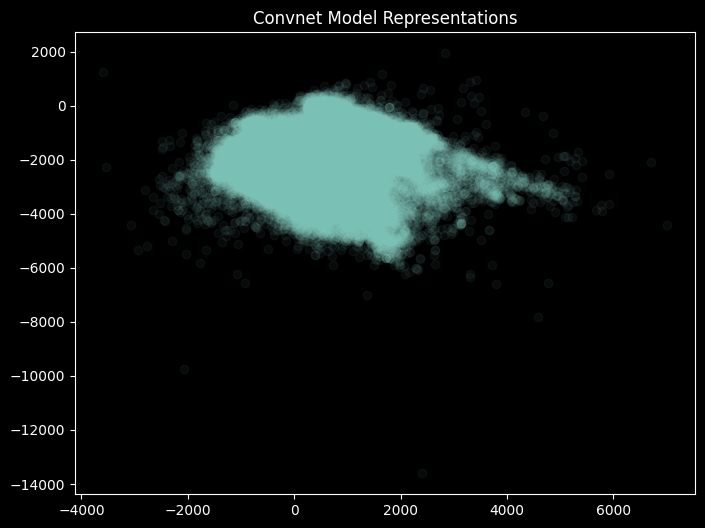

In [42]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(dense_reprs, "Convnet Model Representations")

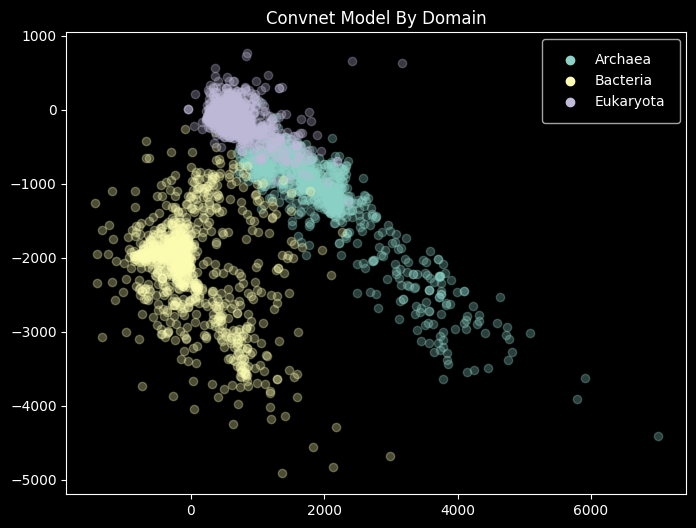

In [43]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(dense_reprs, dataset, 'Domain', 'Convnet Model By Domain')

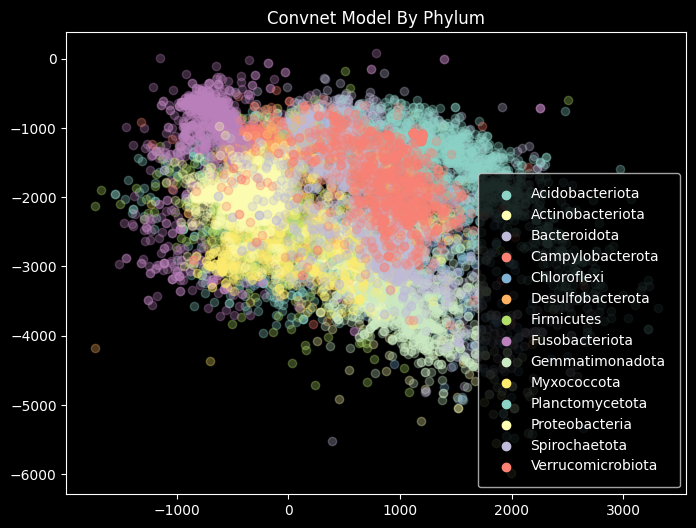

In [44]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(dense_reprs, dataset, 'Phylum', 'Convnet Model By Phylum', filter=1000, mask=mask)

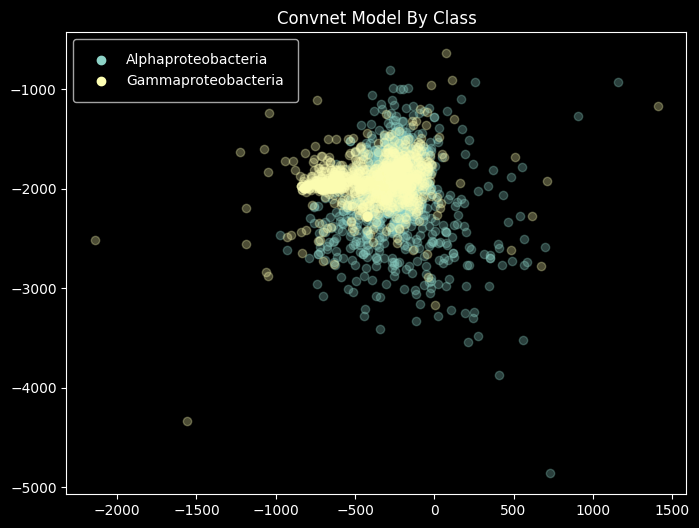

In [45]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(dense_reprs, dataset, 'Class', 'Convnet Model By Class', filter=1000, mask=mask)

## ConvNet

This and the attention models are more powerful in theory, but I found that they perform about the same as a simple dense network, and are thus not worth the computational resources.

In [5]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.conv1D(64, 4)
conv_model = builder.compile(output_dim=2)
conv_model.summary()

Metal device set to: Apple M1 Pro
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 reshape (Reshape)           (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 253, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 126, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                           

2023-01-04 21:03:26.233078: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 21:03:26.233218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
conv_comp = ComparativeEncoder(conv_model, dist=Euclidean())

In [7]:
conv_comp.fit(kmer_counts, batch_size=100, epochs=6, jobs=7, chunksize=500)

Epoch 1:


100%|████████████████████| 334360/334360 [00:13<00:00, 25085.21it/s]
2023-01-04 21:03:47.078324: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 21:03:47.078892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2314
Epoch time: 78.69913291931152
Epoch 2:


100%|████████████████████| 334360/334360 [00:12<00:00, 26183.80it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2185
Epoch time: 78.2213728427887
Epoch 3:


100%|████████████████████| 334360/334360 [00:12<00:00, 26259.58it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2136
Epoch time: 77.88945603370667
Epoch 4:


100%|████████████████████| 334360/334360 [00:13<00:00, 25530.49it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2101
Epoch time: 78.13169622421265
Epoch 5:


100%|████████████████████| 334360/334360 [00:13<00:00, 24784.20it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2096
Epoch time: 78.78330111503601
Epoch 6:


100%|████████████████████| 334360/334360 [00:13<00:00, 24312.21it/s]


3344/3344 [==============================] - 58s 17ms/step - loss: 0.2067
Epoch time: 78.83666610717773


In [15]:
conv_comp.save('Models/convnet')

In [5]:
from SeqRep.comparative_encoder import ComparativeEncoder
conv_comp = ComparativeEncoder.load('Models/convnet')

Metal device set to: Apple M1 Pro


2023-01-04 19:17:45.556706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 19:17:45.556839: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
conv_reprs = conv_comp.transform(kmer_counts, batch_size=100)

  44/3344 [..............................] - ETA: 7s

2023-01-04 21:17:12.712391: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 9s 3ms/step


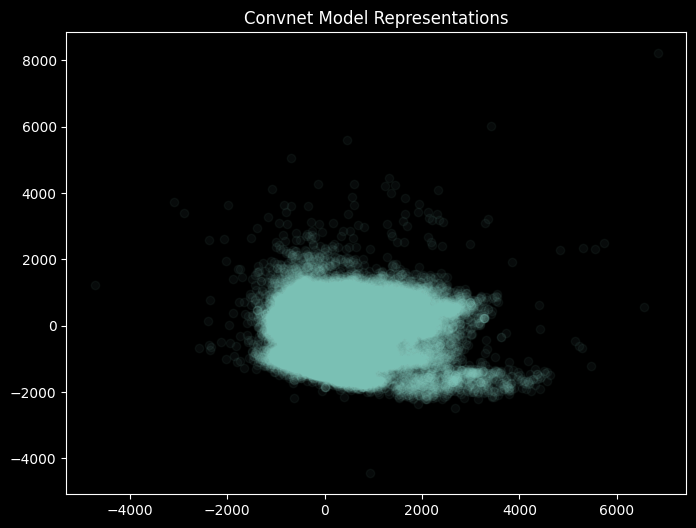

In [9]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(conv_reprs, "Convnet Model Representations")

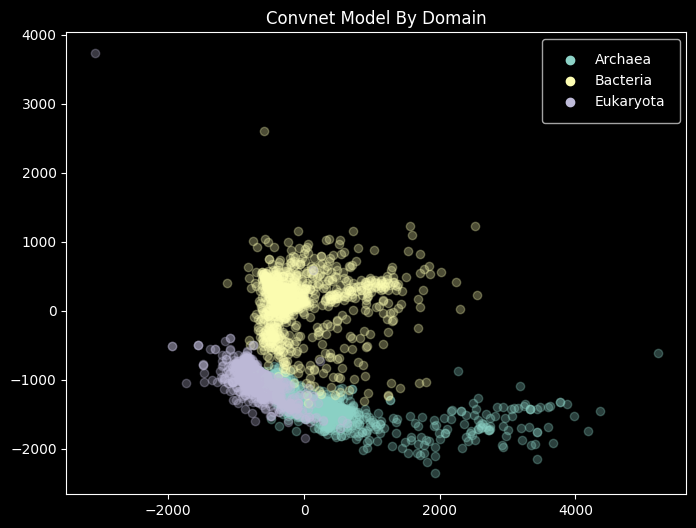

In [10]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(conv_reprs, dataset, 'Domain', 'Convnet Model By Domain')

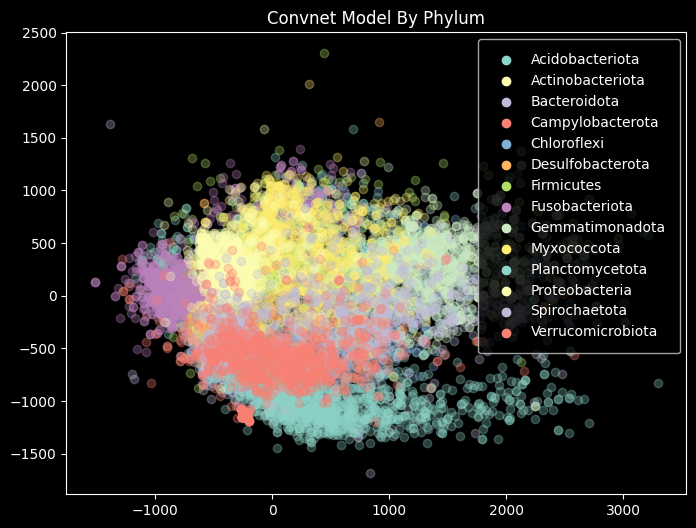

In [11]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(conv_reprs, dataset, 'Phylum', 'Convnet Model By Phylum', filter=1000, mask=mask)

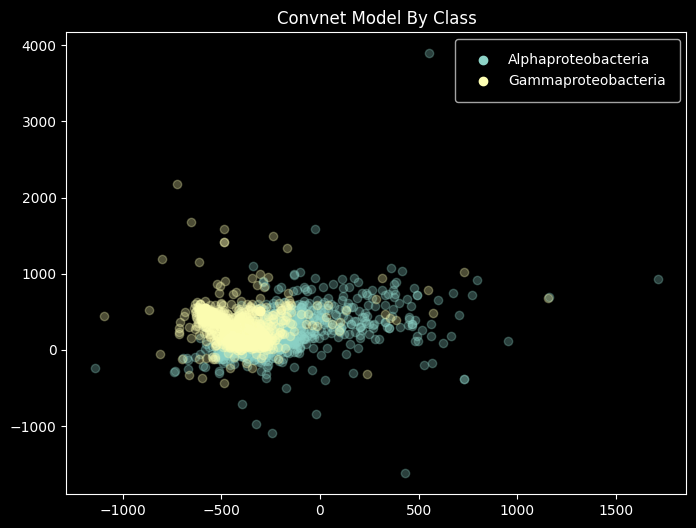

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(conv_reprs, dataset, 'Class', 'Convnet Model By Class', filter=1000, mask=mask)

## Attention Network

In [15]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.attention(4, 2, 128, divide=True)
attn_model = builder.compile(output_dim=2)
attn_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_9 (Dense)             (None, 256)               262400    
                                                                 
 reshape_3 (Reshape)         (None, 64, 4)             0         
                                                                 
 attention_block_2 (Attentio  (None, 64, 4)            1328      
 nBlock)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 64, 4)            16        
 hNormalization)                                                 
                                                                 
 flatten_3 (Flatten)         (None, 256)               0   

In [16]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
attn_comp = ComparativeEncoder(attn_model, dist=Euclidean())

In [17]:
attn_comp.fit(kmer_counts, batch_size=100, epochs=6, jobs=7, chunksize=1000)

Epoch 1:


100%|████████████████████| 334360/334360 [00:15<00:00, 22110.53it/s]
2023-01-04 23:38:23.417353: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 170s 50ms/step - loss: 0.2352
Epoch time: 197.25054597854614
Epoch 2:


100%|████████████████████| 334360/334360 [00:14<00:00, 22834.41it/s]


3344/3344 [==============================] - 166s 49ms/step - loss: 0.2209
Epoch time: 192.10749006271362
Epoch 3:


100%|████████████████████| 334360/334360 [00:14<00:00, 23314.79it/s]


3344/3344 [==============================] - 159s 47ms/step - loss: 0.2178
Epoch time: 185.16431879997253
Epoch 4:


100%|████████████████████| 334360/334360 [00:14<00:00, 23115.08it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2157
Epoch time: 181.48078107833862
Epoch 5:


100%|████████████████████| 334360/334360 [00:14<00:00, 23370.29it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2143
Epoch time: 182.39366722106934
Epoch 6:


100%|████████████████████| 334360/334360 [00:14<00:00, 23190.49it/s]


3344/3344 [==============================] - 157s 47ms/step - loss: 0.2128
Epoch time: 182.93653512001038


In [18]:
attn_comp.save('Models/attn')

In [11]:
from SeqRep.comparative_encoder import ComparativeEncoder
attn_comp = ComparativeEncoder.load('Models/attn')

In [19]:
attn_reprs = attn_comp.transform(kmer_counts, batch_size=100)

2023-01-04 23:57:41.006692: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 40s 12ms/step


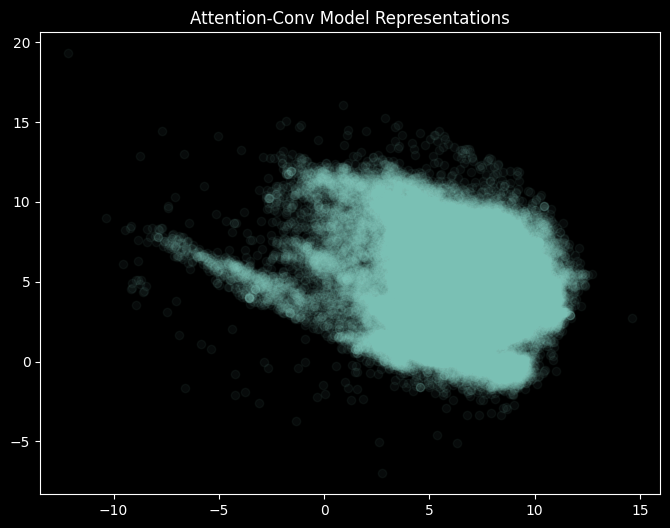

In [20]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(attn_reprs, "Attention-Conv Model Representations")

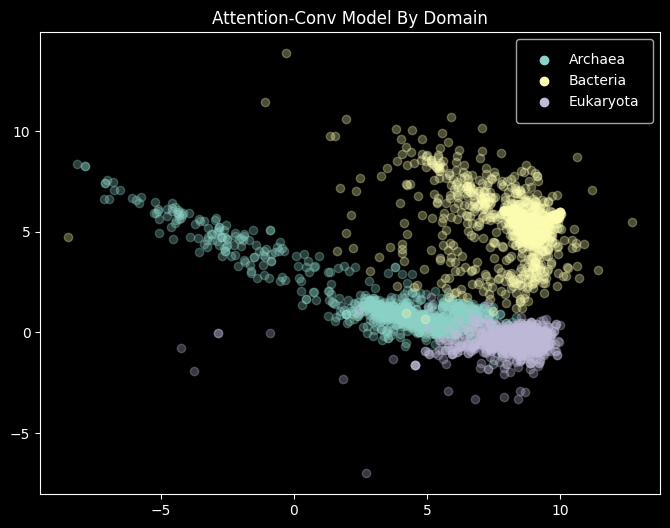

In [21]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(attn_reprs, dataset, 'Domain', 'Attention-Conv Model By Domain')

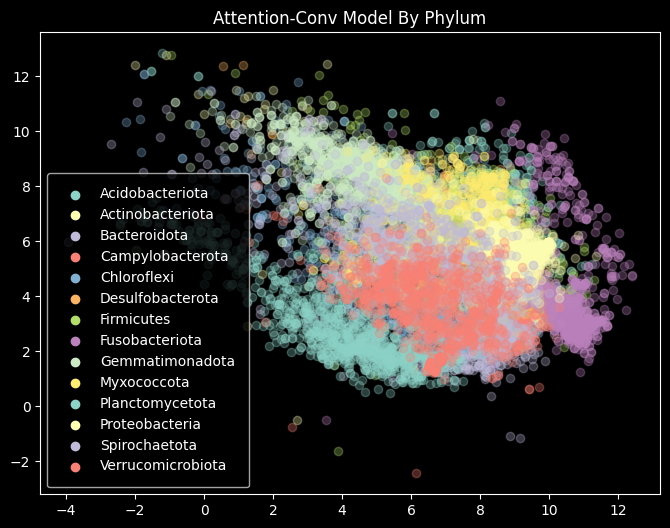

In [22]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(attn_reprs, dataset, 'Phylum', 'Attention-Conv Model By Phylum', filter=1000, mask=mask)

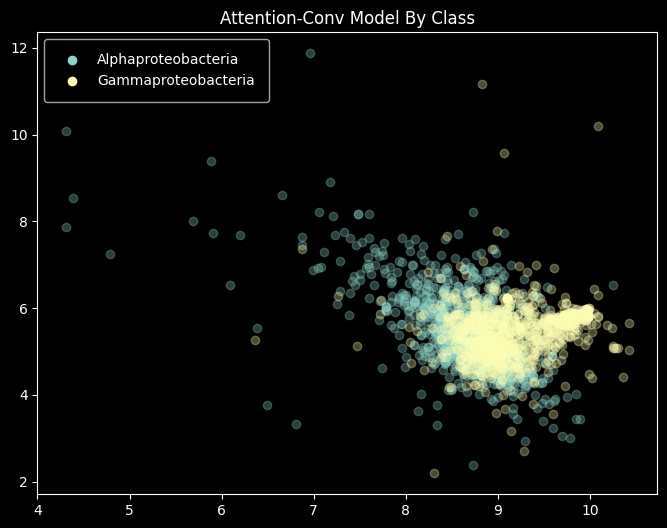

In [23]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(attn_reprs, dataset, 'Class', 'Attention-Conv Model By Class', filter=1000, mask=mask)

## Attention-Conv Network

Unfortunately I accidentally saved the Attention Network model in the same place as this one, so this needs to be retrained.

In [5]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(1024)
builder.dense(256)
builder.conv1D(64, 4)
builder.attention(4, 2, 128, divide=True)
attn_model = builder.compile(output_dim=2)
attn_model.summary()

Metal device set to: Apple M1 Pro


2023-01-04 23:22:15.211064: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 23:22:15.211372: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 reshape (Reshape)           (None, 256, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 253, 64)           320       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 126, 64)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8064)              0         
                                                             

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
attn_comp = ComparativeEncoder(attn_model, dist=Euclidean())

In [7]:
attn_comp.fit(kmer_counts, batch_size=100, epochs=4, jobs=7, chunksize=1000)

Epoch 1:


100%|████████████████████| 334360/334360 [00:11<00:00, 27871.05it/s]
2023-01-04 23:22:36.439302: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 23:22:36.442305: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 158s 47ms/step - loss: 0.2477
Epoch time: 178.37399101257324
Epoch 2:


100%|████████████████████| 334360/334360 [00:12<00:00, 26805.14it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2238
Epoch time: 176.04116916656494
Epoch 3:


100%|████████████████████| 334360/334360 [00:12<00:00, 26189.10it/s]


3344/3344 [==============================] - 157s 47ms/step - loss: 0.2218
Epoch time: 177.37169289588928
Epoch 4:


100%|████████████████████| 334360/334360 [00:12<00:00, 26902.34it/s]


3344/3344 [==============================] - 156s 47ms/step - loss: 0.2154
Epoch time: 176.05519199371338


In [8]:
attn_comp.save('Models/attn-conv')

In [11]:
from SeqRep.comparative_encoder import ComparativeEncoder
attn_comp = ComparativeEncoder.load('Models/attn')

In [9]:
attn_reprs = attn_comp.transform(kmer_counts, batch_size=100)

2023-01-04 23:35:14.519788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 34s 10ms/step


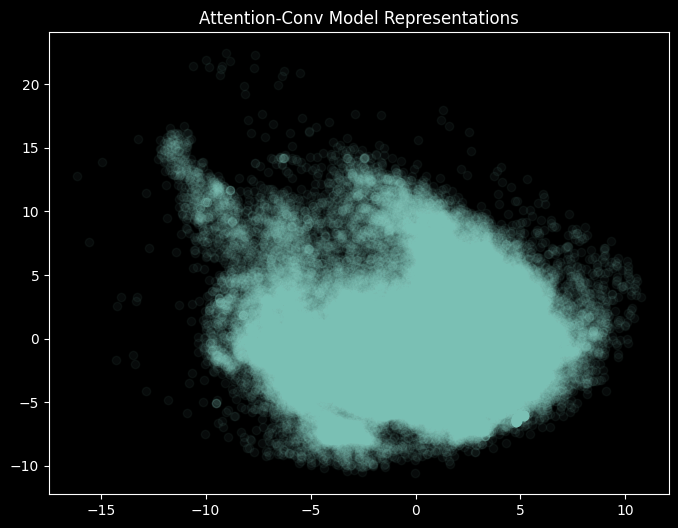

In [10]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(attn_reprs, "Attention-Conv Model Representations")

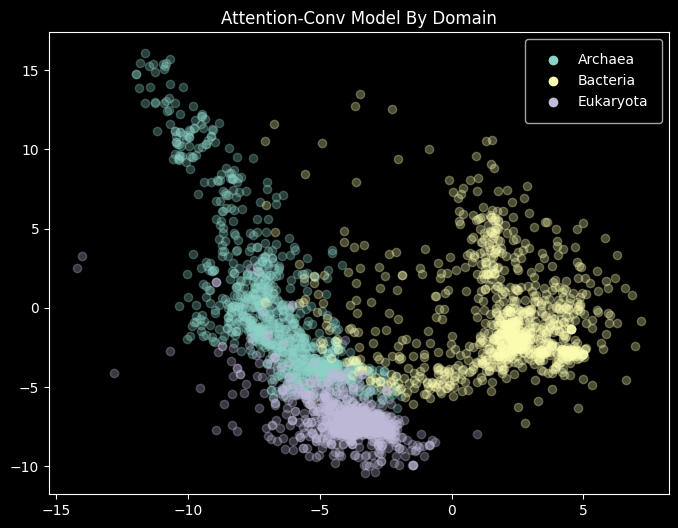

In [11]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(attn_reprs, dataset, 'Domain', 'Attention-Conv Model By Domain')

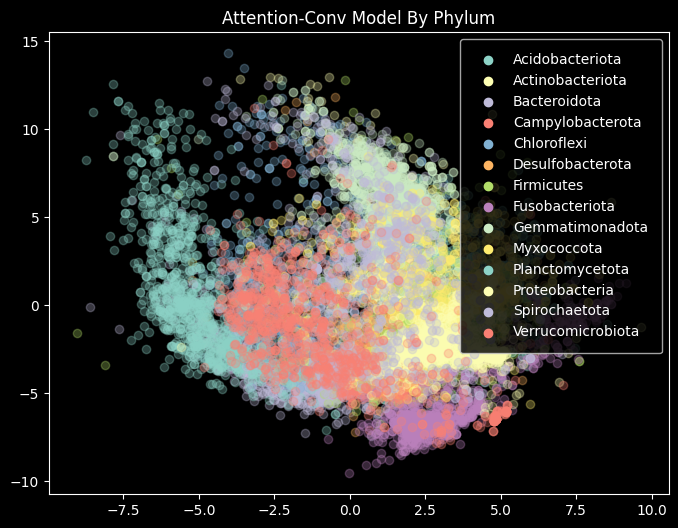

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(attn_reprs, dataset, 'Phylum', 'Attention-Conv Model By Phylum', filter=1000, mask=mask)

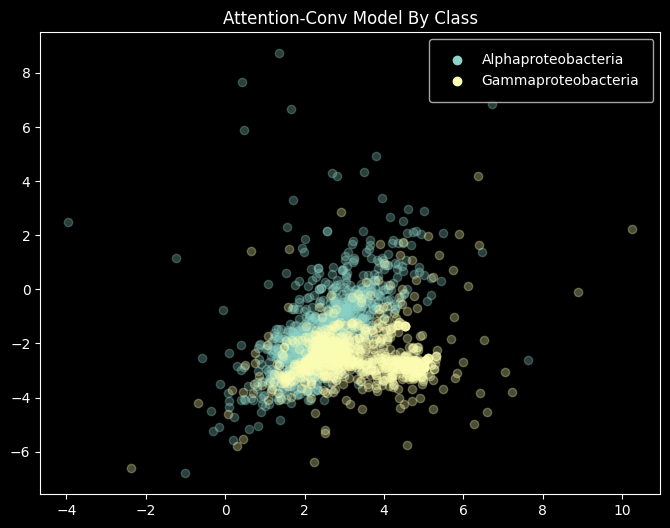

In [13]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(attn_reprs, dataset, 'Class', 'Attention-Conv Model By Class', filter=1000, mask=mask)

## Sequential Model

This model is a less powerful version of my original sequence representation model that's (barely) capable of training on my personal laptop. While it still analyzes raw sequences, it uses K-Mers distancing as opposed to alignment comparison (as well as has fewer parameters due to computational restrictions). With the resources I have, this underperforms the above models. However, with more computing power from TACC and some additions to the library, it would be easily possible to recreate my original model and replicate its results.

In [4]:
dataset.trim_seqs(300)

In [5]:
encoded = dataset.one_hot_encode(jobs=7, chunksize=50)

100%|████████████████████| 334360/334360 [00:15<00:00, 21105.78it/s]


In [6]:
from SeqRep.encoders import ModelBuilder
builder = ModelBuilder(encoded.shape[1:])
builder.flatten()
builder.dense(300)
builder.conv1D(128, 4, divide=4)
builder.attention(4, 2, 250, divide=False)
seq_model = builder.compile(output_dim=2)
seq_model.summary()

Metal device set to: Apple M1 Pro


2023-01-04 22:57:46.764052: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 22:57:46.764194: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 5)]          0         
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense (Dense)               (None, 300)               450300    
                                                                 
 reshape (Reshape)           (None, 75, 4)             0         
                                                                 
 conv1d (Conv1D)             (None, 72, 128)           2176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 36, 128)          0         
 )                                                               
                                                             

In [7]:
from SeqRep.comparative_encoder import ComparativeEncoder
from SeqRep.distance import Euclidean
seq_comp = ComparativeEncoder(seq_model, dist=Euclidean())

In [13]:
seq_comp.fit(encoded, batch_size=100, epochs=1, jobs=7, chunksize=500, distance_on=kmer_counts)

Epoch 1:


100%|████████████████████| 334360/334360 [00:15<00:00, 20921.11it/s]


TypeError: in user code:

    File "/Users/NikhilKalidasu/miniforge3/envs/tensorflow/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/Users/NikhilKalidasu/Documents/DNA Visualization/dna-dataset-visualization/SeqRep/comparative_encoder.py", line 23, in correlation_coefficient_loss  *
        r_num = K.sum(tf.multiply(xm, ym))

    TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.


In [ ]:
seq_comp.save('Models/seq_attn')

In [6]:
from SeqRep.comparative_encoder import ComparativeEncoder
seq_comp = ComparativeEncoder.load('Models/seq_attn')

Metal device set to: Apple M1 Pro


2023-01-04 23:01:50.008607: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 23:01:50.008733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
seq_reprs = seq_comp.transform(encoded, batch_size=100)

2023-01-04 23:02:08.810291: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 23:02:08.876768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3344/3344 [==============================] - 62s 19ms/step


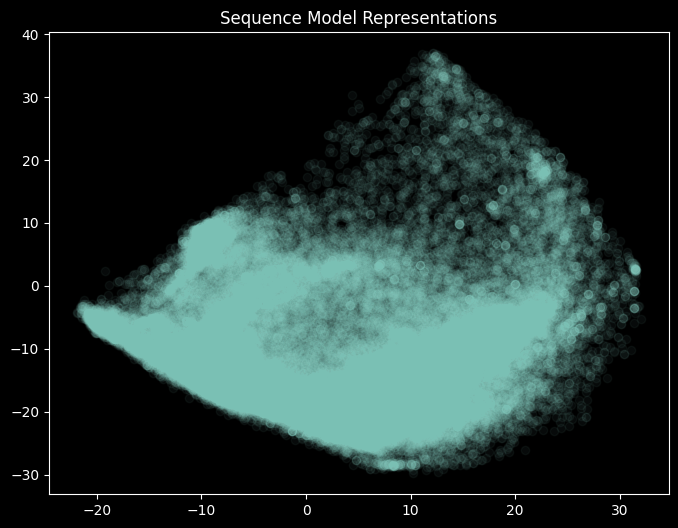

In [9]:
from SeqRep.visualize import repr_scatterplot
repr_scatterplot(seq_reprs, "Sequence Model Representations")

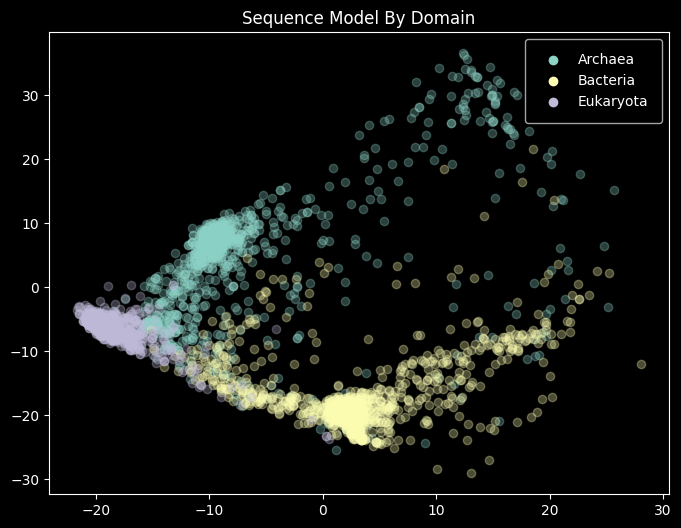

In [10]:
from SeqRep.visualize import reprs_by_taxa
reprs_by_taxa(seq_reprs, dataset, 'Domain', 'Sequence Model By Domain')

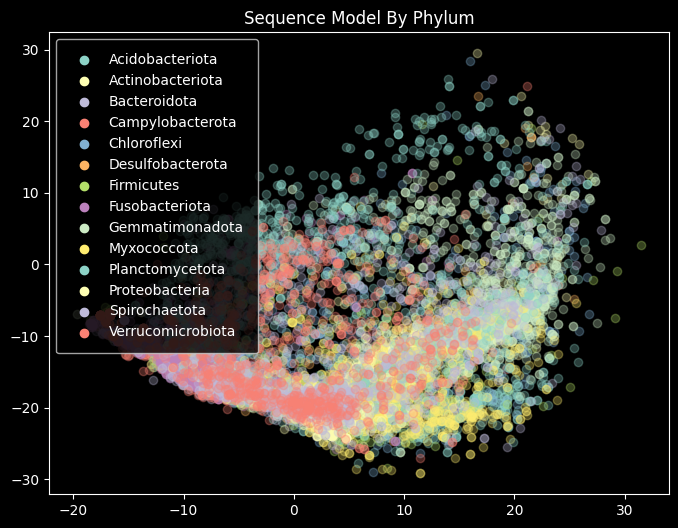

In [11]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Domain', 'Bacteria')
reprs_by_taxa(seq_reprs, dataset, 'Phylum', 'Sequence Model By Phylum', filter=1000, mask=mask)

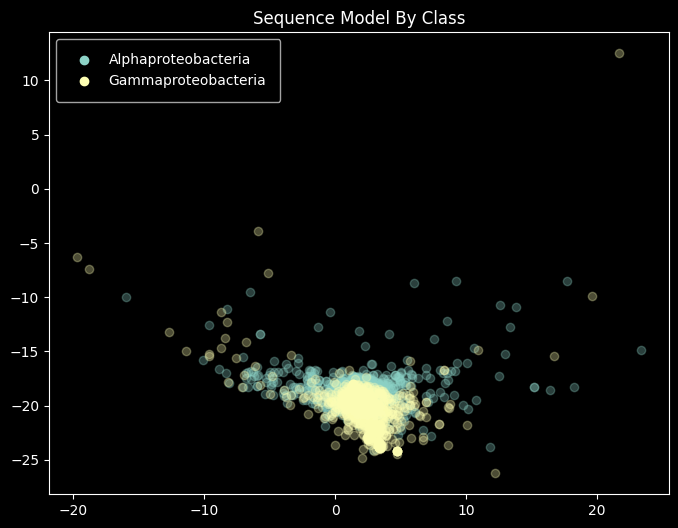

In [12]:
from SeqRep.visualize import reprs_by_taxa
mask = dataset['tax'].tax_mask('Phylum', 'Proteobacteria')
reprs_by_taxa(seq_reprs, dataset, 'Class', 'Sequence Model By Class', filter=1000, mask=mask)